In [22]:
# データセットダウンロード
!wget http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip

--2018-07-20 03:54:29--  http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
Resolving www.nurs.or.jp (www.nurs.or.jp)... 54.187.126.238
Connecting to www.nurs.or.jp (www.nurs.or.jp)|54.187.126.238|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 592335393 (565M) [application/zip]
Saving to: ‘animeface-character-dataset.zip’

animeface-character 100%[===================>] 564.89M  35.0MB/s    in 17s     

2018-07-20 03:54:46 (32.4 MB/s) - ‘animeface-character-dataset.zip’ saved [592335393/592335393]



In [0]:
# 解凍
!unzip -qq  animeface-character-dataset.zip

In [48]:
# ファイルの確認
!ls animeface-character-dataset/thumb/000_hatsune_miku/

color.csv	      face_328_209_46.png   face_553_15_24.png
face_128_326_108.png  face_332_124_33.png   face_559_356_147.png
face_136_245_126.png  face_341_160_137.png  face_560_145_77.png
face_165_132_79.png   face_357_256_119.png  face_563_56_31.png
face_168_638_76.png   face_361_115_129.png  face_568_250_96.png
face_208_170_115.png  face_363_253_144.png  face_569_132_132.png
face_209_55_78.png    face_370_580_110.png  face_574_143_89.png
face_214_99_108.png   face_385_110_90.png   face_585_237_117.png
face_227_303_150.png  face_392_130_71.png   face_590_180_107.png
face_250_136_15.png   face_398_290_65.png   face_604_367_106.png
face_250_181_154.png  face_404_144_123.png  face_632_189_54.png
face_260_173_131.png  face_409_197_37.png   face_638_172_18.png
face_265_170_51.png   face_412_76_108.png   face_641_448_151.png
face_27_136_113.png   face_422_672_7.png    face_670_483_89.png
face_277_225_56.png   face_429_214_130.png  face_711_34_83.png
face_286_77_58.png    face_447_216_121.png 

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2

In [0]:
# 画像の読み込み
files = glob.glob( "animeface-character-dataset/thumb/*/*.png" )
images = []

for f in files:
    img = cv2.imread( f, 0 )
    img = cv2.resize(img, (112,112))
    images.append(img)

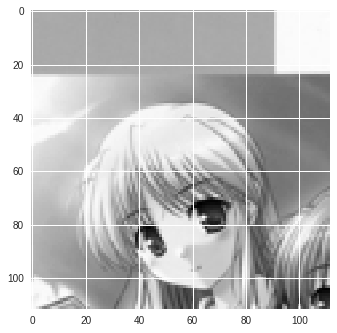

In [50]:
# 画像の確認
plt.imshow( images[0], cmap="gray" )

In [0]:
# 各種行列を生成する関数
def weight_variable(shape, name):
    initial = tf.random_normal(shape,stddev=0.02)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.random_normal(shape, stddev=0.02)
    return tf.Variable(initial, name=name)

In [0]:
def batch_normalizaiton( x, axes=[0] ):
    mean, variance = tf.nn.moments( x, axes )
    return tf.nn.batch_normalization( x, mean, variance, None, None, 1e-5 )

In [0]:
batch_size = 100
latent_dim = 100

In [0]:
# generatorの重みを定義
g_W1 = weight_variable( [latent_dim, 1024], "g_w1" )
g_b1 = bias_variable( [1024] , "g_b1")
g_W2 = weight_variable( [1024, 128*7*7], "g_w2" )
g_b2 = bias_variable( [128*7*7], "g_b2" )
g_W3 = weight_variable( [5, 5, 64, 128], "g_w3" )
g_b3 = bias_variable( [64], "g_b3" )
g_W4 = weight_variable( [5,5,1,64], "g_w4" )
g_b4 = bias_variable( [1], "g_b4" )

# generatorのネットワークを構築する関数
def construct_generator( Z ):
    ## 全結合
    fc1 = tf.matmul( Z, g_W1 ) + g_b1

    ## batch normalization
    bn1 = batch_normalizaiton( fc1 )

    ## relu
    relu1 = tf.nn.relu( bn1 )

    ## 全結合
    fc2 = tf.matmul( relu1, g_W2 ) + g_b2

    ## batch normalization
    bn2 = batch_normalizaiton( fc2 )

    ## relu
    relu2 = tf.nn.relu( bn2 )

    # reshapeで画像化
    y2 = tf.reshape( relu2, [batch_size, 7, 7, 128] )

    ## 転置畳み込み
    conv_t1 = tf.nn.conv2d_transpose( y2, g_W3, strides=[1,4,4,1], output_shape=[batch_size, 28, 28, 64] ) + g_b3

    ## batch normalization
    bn3 = batch_normalizaiton( conv_t1, [0,1,2] )

    ## relu
    relu3 = tf.nn.relu( bn3 )

    # 転置畳み込み
    conv_t2 = tf.nn.conv2d_transpose( relu3, g_W4, strides=[1,4,4,1], output_shape=[batch_size, 112, 112, 1] ) + g_b4

    # 画像生成
    img = tf.nn.sigmoid( conv_t2 )
    
    return img

In [0]:
# discriminatorの重み
d_W1 = weight_variable([5,5,1,64], "d_w1")
d_b1 = bias_variable( [64], "d_b1" )
d_W2 = weight_variable( [5,5,64,128], "d_w2" )
d_b2 = bias_variable( [128], "d_b2" )
d_W3 = weight_variable( [128*7*7, 1024], "d_w3" )
d_b3 = bias_variable( [1024] , "d_b3")
d_W4 = weight_variable([1024, 1], "d_w4")
d_b4 = bias_variable( [1], "d_b4" )
        
# discriminatorのネットワークを構築する関数
def construct_discriminator( img):
        # 畳み込み
        conv1 = tf.nn.conv2d(img, d_W1, strides=[1,4,4,1], padding="SAME") + d_b1

        # leaky relu
        y1 = tf.nn.leaky_relu(conv1)

        # 畳み込み
        conv2 = tf.nn.conv2d(y1, d_W2, strides=[1,4,4,1], padding="SAME") + d_b2

        # leaky leru
        y2 = tf.nn.leaky_relu(conv2)
        
        # ベクトルに直す
        y2 = tf.reshape( y2, [-1, 7*7*128] )
        
        # 全結合
        fc1 = tf.matmul(y2, d_W3) + d_b3

        # leaky relu
        y3 = tf.nn.leaky_relu(fc1)

        # 全結合
        fc2 = tf.matmul(y3, d_W4) + d_b4
        
        # 入力された画像が本物である確率（0～1）に直す
        prob = tf.nn.sigmoid(fc2)
        
        return prob

In [0]:
# モデル構築
## generatorへの入力
Z = tf.placeholder(tf.float32, [batch_size, latent_dim]) 

## Discriminatorが識別する画像
img_real = tf.placeholder(tf.float32, [batch_size, 112, 112, 1]) 
img_gen = construct_generator(Z)

## 本物か偽物か判別
p_real = construct_discriminator(img_real)
p_gen = construct_discriminator(img_gen)

## コスト関数
## descriminator: 本物は本物である確率p_realが大きくなるように，偽物に対しては偽物である確率1-p_genが大きくなるように学習
discrim_cost = tf.reduce_mean(-tf.reduce_sum(tf.log(p_real) + tf.log(tf.ones(batch_size, tf.float32) - p_gen), axis=1))

## generator: 偽物img_genが本物である確率p_genが高くなるように学習
gen_cost = tf.reduce_mean(-tf.reduce_sum(tf.log(p_gen), axis=1))

In [0]:
# 最適化法を設定
## discriminatorの変数のみを更新
discrim_vars = [x for x in tf.trainable_variables() if "d_" in x.name]
optimizer_d = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(discrim_cost, var_list=discrim_vars)

## generatorの変数のみを更新
gen_vars = [x for x in tf.trainable_variables() if "g_" in x.name]
optimizer_g = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(gen_cost, var_list=gen_vars)

In [58]:
itr = 0
n_epochs = 500

# 学習
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for epoch in range(n_epochs):
      #images = mnist.test.images
      images = np.array(images)
      np.random.shuffle(images)
      N = len(images)

      for start in range(0, N-batch_size, batch_size):
          end = start + batch_size

          # 正規化
          img_bach = images[start:end].reshape([-1, 112,112,1]) / 255.

          # Zをランダムに生成
          random_Z = np.random.uniform(-1,1, size=[batch_size, latent_dim]).astype(np.float32)

          # generator学習
          feed_dict = {Z: random_Z}
          _, gen_loss = sess.run([optimizer_g, gen_cost], feed_dict=feed_dict) 

          # discriminator学習
          feed_dict = {Z: random_Z, img_real: img_bach}
          _, discrim_loss = sess.run([optimizer_d, discrim_cost], feed_dict=feed_dict)

          itr += 1

      print("epoch=%d, gen_loss=%lf, dicrim_loss=%lf" % (epoch, gen_loss, discrim_loss) )

      # 表示と保存
      if epoch%10==0:
        feed_dict = {Z: random_Z}
        img = sess.run( [img_gen], feed_dict=feed_dict  )
        plt.clf()
        for i in range(25):
            plt.subplot( 5, 5, i+1 )
            plt.imshow( img[0][i].reshape(112,112), cmap="gray" )
        plt.show()
